# Trabajo Práctico 4 - Big Data, Aprendizaje y Minería de Datos


## Grupo: 

* Alexander Pacheco
* Rafael Paganini
* Alan Starobinski

## Parte I: Análisis de la base de hogares y cálculo de pobreza

In [1]:
# Se importan los paquetes y comandos necesarios para trabajar con metodologías de clasificación

import os  
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt  
import statsmodels.api as sm
import sklearn
import statistics
import time
import IPython
import warnings
import seaborn as sns

!pip install prettytable

from sklearn import datasets
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, recall_score 
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import precision_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold
from sklearn.preprocessing import scale
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from matplotlib.image import imread
from prettytable import PrettyTable

In [2]:
# Definimos el directorio

#os.chdir(r'C:\Users\alans\OneDrive\Documents\TP Ridge Lasso')
#os.chdir(r'C:\Users\Rafael\Desktop\Cosas\Encare\Master UdeSA\Tercer trimestre\Big Data\TPs\TP3')
os.chdir('/Users/alexanderpacheco/Desktop/Mecon_udesa/big_data/TPS/TP3')



### Inciso 1

In [3]:
# Descargamos la EPH a nivel de hogar
df_eph_hog = pd.read_excel("usu_hogar_T123.xlsx")
df_eph_hog.head(5)

,CODUSU,ANO4,TRIMESTRE,NRO_HOGAR,REALIZADA,REGION,MAS_500,AGLOMERADO,PONDERA,IV1,...,GDECCFR,PDECCFR,ADECCFR,PONDIH,VII1_1,VII1_2,VII2_1,VII2_2,VII2_3,VII2_4
0,TQRMNOPSRHJMKNCDEHLEH00797939,2023,1,1,1,40,N,25,111,2,...,NaN,3.0,3,124,1,2,98,0,0,0
1,TQRMNORQYHLMKPCDEHLEH00717341,2023,1,1,1,40,N,25,150,1,...,NaN,5.0,7,193,2,0,98,0,0,0
2,TQRMNOPUWHLLKSCDEHLEH00798181,2023,1,1,1,40,N,25,156,2,...,NaN,5.0,6,185,1,0,98,0,0,0
3,TQRMNOSSWHKOKRCDEGOIH00778157,2023,1,1,1,40,N,18,229,1,...,NaN,2.0,2,228,2,0,1,0,0,0
4,TQRMNORPUHJMKSCDEGOIH00794685,2023,1,1,1,40,N,18,182,1,...,NaN,5.0,6,194,1,0,97,0,0,0


In [4]:
print('La muestra completa contiene', len(df_eph_hog), 'observaciones')

La muestra completa contiene 16815 observaciones


In [5]:
# Nos quedamos con las observaciones de Ciudad Autónoma de Buenos Aires y Gran Buenos Aires
df_ba_hog = df_eph_hog[(df_eph_hog['AGLOMERADO'] == 32) | (df_eph_hog['AGLOMERADO'] == 33)]
print('Ahora tenemos', len(df_ba_hog), 'observaciones.')

Ahora tenemos 2736 observaciones.


### Inciso 2

In [6]:
# Descargamos la EPH a nivel individual
df_eph_ind = pd.read_excel("usu_individual_T123.xlsx")
df_eph_ind.head(5)

,CODUSU,ANO4,TRIMESTRE,NRO_HOGAR,COMPONENTE,H15,REGION,MAS_500,AGLOMERADO,PONDERA,...,PDECIFR,ADECIFR,IPCF,DECCFR,IDECCFR,RDECCFR,GDECCFR,PDECCFR,ADECCFR,PONDIH
0,TQRMNORVWHLMKOCDEOHCH00720228,2023,1,1,5,0,44,N,91,112,...,10.0,9,79700.0,6,6.0,5,NaN,7.0,5,133
1,TQRMNOPSTHKMKPCDEOHCH00781447,2023,1,1,1,1,44,N,91,190,...,6.0,5,180000.0,9,10.0,9,NaN,10.0,9,200
2,TQRMNOQSXHMOKRCDEOHCH00803177,2023,1,1,1,1,44,N,91,134,...,8.0,8,145000.0,9,9.0,8,NaN,9.0,8,140
3,TQRMNOQSXHMOKRCDEOHCH00803177,2023,1,1,2,1,44,N,91,134,...,8.0,8,145000.0,9,9.0,8,NaN,9.0,8,140
4,TQRMNOQYTHMNKSCDEOHCH00803178,2023,1,1,1,1,44,N,91,120,...,12.0,12,0.0,12,12.0,12,NaN,12.0,12,0


In [7]:
print('La base completa de individuos contiene', len(df_eph_hog), 'observaciones')

La base completa de individuos contiene 16815 observaciones


In [8]:
# Nos quedamos con las observaciones de Ciudad Autónoma de Buenos Aires y Gran Buenos Aires
df_ba_ind = df_eph_ind[(df_eph_ind['AGLOMERADO'] == 32) | (df_eph_ind['AGLOMERADO'] == 33)]
print('Ahora la base de individuos tiene', len(df_ba_ind), 'observaciones.')

Ahora la base de individuos tiene 7619 observaciones.


In [9]:
# Mergeamos ambas bases
df_eph = df_ba_hog.merge(df_ba_ind,on=['CODUSU', 'NRO_HOGAR'], how='left', suffixes=('', '_ind'))
df_eph.head(5)

,CODUSU,ANO4,TRIMESTRE,NRO_HOGAR,REALIZADA,REGION,MAS_500,AGLOMERADO,PONDERA,IV1,...,PDECIFR_ind,ADECIFR_ind,IPCF_ind,DECCFR_ind,IDECCFR_ind,RDECCFR_ind,GDECCFR_ind,PDECCFR_ind,ADECCFR_ind,PONDIH_ind
0,TQRMNORVYHMOTSCDEIJAH00802517,2023,1,1,1,1,S,33,1066,1,...,NaN,12,0.0,12,NaN,12,12.0,NaN,12,0
1,TQRMNORVYHMOTSCDEIJAH00802517,2023,1,1,1,1,S,33,1066,1,...,NaN,12,0.0,12,NaN,12,12.0,NaN,12,0
2,TQRMNOSQRHLLTTCDEIJAH00719390,2023,1,1,1,1,S,33,2270,2,...,NaN,5,79000.0,6,NaN,6,6.0,NaN,7,4733
3,TQRMNOSQRHLLTTCDEIJAH00719390,2023,1,1,1,1,S,33,2270,2,...,NaN,5,79000.0,6,NaN,6,6.0,NaN,7,4733
4,TQSMNOSQRHLLTTCDEIJAH00719389,2023,1,1,1,1,S,33,2161,1,...,NaN,3,96000.0,7,NaN,7,7.0,NaN,8,2672


In [10]:
#Sabemos que hay columnas repetidas entre ambos archivos Excel

print(df_eph)

                             CODUSU  ANO4  TRIMESTRE  NRO_HOGAR  REALIZADA  \
0     TQRMNORVYHMOTSCDEIJAH00802517  2023          1          1          1   
1     TQRMNORVYHMOTSCDEIJAH00802517  2023          1          1          1   
2     TQRMNOSQRHLLTTCDEIJAH00719390  2023          1          1          1   
3     TQRMNOSQRHLLTTCDEIJAH00719390  2023          1          1          1   
4     TQSMNOSQRHLLTTCDEIJAH00719389  2023          1          1          1   
...                             ...   ...        ...        ...        ...   
7614  TQRMNOSSQHKOOMCDEIJAH00802644  2023          1          1          1   
7615  TQRMNOSSQHKOOMCDEIJAH00802644  2023          1          1          1   
7616  TQRMNOSSQHKOOMCDEIJAH00802644  2023          1          1          1   
7617  TQRMNORYPHJKNPCDEIJAH00794297  2023          1          1          1   
7618  TQRMNORYPHJKNPCDEIJAH00794297  2023          1          1          1   

      REGION MAS_500  AGLOMERADO  PONDERA  IV1  ... PDECIFR_ind

In [11]:
#Conocemos cuales son las repetidas

columnas_duplicadas = []

for columna in df_eph.columns:
    if columna.endswith("_ind"):
        columna_sin_sufijo = columna.rstrip("_ind")
        if columna_sin_sufijo in df_eph.columns:
            if (df_eph[columna] == df_eph[columna_sin_sufijo]).all():
                columnas_duplicadas.append((columna_sin_sufijo, columna))

if columnas_duplicadas:
    print("Columnas con contrapartes _ind que son iguales:")
    for dupla in columnas_duplicadas:
        print(f"{dupla[0]} y {dupla[1]} son iguales.")
else:
    print("No hay columnas con contrapartes _ind iguales.")

Columnas con contrapartes _ind que son iguales:
ANO4 y ANO4_ind son iguales.
TRIMESTRE y TRIMESTRE_ind son iguales.
REGION y REGION_ind son iguales.
MAS_500 y MAS_500_ind son iguales.
AGLOMERADO y AGLOMERADO_ind son iguales.
PONDERA y PONDERA_ind son iguales.
ITF y ITF_ind son iguales.
DECIFR y DECIFR_ind son iguales.
RDECIFR y RDECIFR_ind son iguales.
GDECIFR y GDECIFR_ind son iguales.
ADECIFR y ADECIFR_ind son iguales.
IPCF y IPCF_ind son iguales.
DECCFR y DECCFR_ind son iguales.
RDECCFR y RDECCFR_ind son iguales.
GDECCFR y GDECCFR_ind son iguales.
ADECCFR y ADECCFR_ind son iguales.
PONDIH y PONDIH_ind son iguales.


In [12]:
# Probamos un ejemplo de las repetidas

df_eph['TRIMESTRE'].equals(df_eph['TRIMESTRE_ind'])

True

In [13]:
# Elimina las columnas duplicadas con el sufijo "_ind"
for dupla in columnas_duplicadas:
    columna_sin_sufijo = dupla[0]
    columna_con_sufijo = dupla[1]
    df_eph.drop(columns=columna_con_sufijo, inplace=True)

print("Columnas duplicadas eliminadas.")

Columnas duplicadas eliminadas.


In [14]:
#Ahora vemos que hay menos cantidad de columnas porque eliminamos correctamente las repetidas, antes teníamos 263
#Ahora tenemos 246


print(df_eph)


                             CODUSU  ANO4  TRIMESTRE  NRO_HOGAR  REALIZADA  \
0     TQRMNORVYHMOTSCDEIJAH00802517  2023          1          1          1   
1     TQRMNORVYHMOTSCDEIJAH00802517  2023          1          1          1   
2     TQRMNOSQRHLLTTCDEIJAH00719390  2023          1          1          1   
3     TQRMNOSQRHLLTTCDEIJAH00719390  2023          1          1          1   
4     TQSMNOSQRHLLTTCDEIJAH00719389  2023          1          1          1   
...                             ...   ...        ...        ...        ...   
7614  TQRMNOSSQHKOOMCDEIJAH00802644  2023          1          1          1   
7615  TQRMNOSSQHKOOMCDEIJAH00802644  2023          1          1          1   
7616  TQRMNOSSQHKOOMCDEIJAH00802644  2023          1          1          1   
7617  TQRMNORYPHJKNPCDEIJAH00794297  2023          1          1          1   
7618  TQRMNORYPHJKNPCDEIJAH00794297  2023          1          1          1   

      REGION MAS_500  AGLOMERADO  PONDERA  IV1  ... V11_M  V12_

In [15]:
print('Ahora tenemos', len(df_eph), 'observaciones.')

Ahora tenemos 7619 observaciones.


### Inciso 3

In [16]:
# Se eliminan las variables para las que el porcentaje de valores faltantes supera al 50% de la muestra

# Se calcula el porcentaje de valores faltantes para cada variable
porc_missing = (df_eph.isna().mean() * 100)

# Se indexan las variables con un porcentaje de valores faltantes superior a 50%
se_dropean_3 = porc_missing[porc_missing > 50].index

# Se eliminan esas variables
df_eph = df_eph.drop(se_dropean_3, axis=1)

# Lista de variables incluidas
column_names = df_eph.columns.tolist()
print(column_names)


['CODUSU', 'ANO4', 'TRIMESTRE', 'NRO_HOGAR', 'REALIZADA', 'REGION', 'MAS_500', 'AGLOMERADO', 'PONDERA', 'IV1', 'IV2', 'IV3', 'IV4', 'IV5', 'IV6', 'IV7', 'IV8', 'IV9', 'IV10', 'IV11', 'IV12_1', 'IV12_2', 'IV12_3', 'II1', 'II2', 'II3', 'II3_1', 'II4_1', 'II4_2', 'II4_3', 'II5', 'II5_1', 'II6', 'II6_1', 'II7', 'II8', 'II9', 'V1', 'V2', 'V21', 'V22', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19_A', 'V19_B', 'IX_TOT', 'IX_MEN10', 'IX_MAYEQ10', 'ITF', 'DECIFR', 'RDECIFR', 'GDECIFR', 'ADECIFR', 'IPCF', 'DECCFR', 'RDECCFR', 'GDECCFR', 'ADECCFR', 'PONDIH', 'VII1_1', 'VII1_2', 'VII2_1', 'VII2_2', 'VII2_3', 'VII2_4', 'COMPONENTE', 'H15', 'CH03', 'CH04', 'CH05', 'CH06', 'CH07', 'CH08', 'CH09', 'CH10', 'CH11', 'CH12', 'CH13', 'CH15', 'CH16', 'NIVEL_ED', 'ESTADO', 'CAT_OCUP', 'CAT_INAC', 'PP02C1', 'PP02C2', 'PP02C3', 'PP02C4', 'PP02C5', 'PP02C6', 'PP02C7', 'PP02C8', 'PP02E', 'PP02H', 'PP02I', 'P21', 'DECOCUR', 'RDECOCUR', 'GDECOCUR', '

In [17]:
# Se eliminan las edades negativas de la base
df_eph = df_eph[df_eph['CH06'] >= 0]


# Se toman solo las observaciones mayores a cero de los ingresos de la ocupación principal de los asalariados

df_eph = df_eph[df_eph['ITF'] >= 0]
df_eph = df_eph[df_eph['IPCF'] >= 0]

# Se toman solo las observaciones mayores a cero de los ingresos no laborales

df_eph = df_eph[df_eph['V2_M'] >= 0]
df_eph = df_eph[df_eph['V3_M'] >= 0]
df_eph = df_eph[df_eph['V4_M'] >= 0]
df_eph = df_eph[df_eph['V5_M'] >= 0]
df_eph = df_eph[df_eph['V8_M'] >= 0]
df_eph = df_eph[df_eph['V9_M'] >= 0]
df_eph = df_eph[df_eph['V10_M'] >= 0]
df_eph = df_eph[df_eph['V11_M'] >= 0]
df_eph = df_eph[df_eph['V12_M'] >= 0]
df_eph = df_eph[df_eph['V18_M'] >= 0]
df_eph = df_eph[df_eph['V19_AM'] >= 0]
df_eph = df_eph[df_eph['V21_M'] >= 0]
df_eph = df_eph[df_eph['T_VI'] >= 0]


print('Ahora tenemos', len(df_eph), 'observaciones')


Ahora tenemos 7140 observaciones


In [18]:
# Se corrobora que ya no quedan valores faltantes relevantes

# Se fija la opción para poder visualizar toda la lista de variables restantes al final de la celda
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# Cuenta los valores faltantes para cada variable Count missing values for each variable in the DataFrame 'respondieron'
missing = df_eph.isna().sum()

# Display the missing value counts
print(missing)

# Se deshace la opción que fuerza a no omitir valores de las cosas que se muestran
pd.reset_option('display.max_rows')
pd.reset_option('display.max_columns')

#Solo nos quedó P4T7 con 23 missings, y será eliminadaa en la Parte III por ser de ingreso

CODUSU         0
ANO4           0
TRIMESTRE      0
NRO_HOGAR      0
REALIZADA      0
REGION         0
MAS_500        0
AGLOMERADO     0
PONDERA        0
IV1            0
IV2            0
IV3            0
IV4            0
IV5            0
IV6            0
IV7            0
IV8            0
IV9            0
IV10           0
IV11           0
IV12_1         0
IV12_2         0
IV12_3         0
II1            0
II2            0
II3            0
II3_1          0
II4_1          0
II4_2          0
II4_3          0
II5            0
II5_1          0
II6            0
II6_1          0
II7            0
II8            0
II9            0
V1             0
V2             0
V21            0
V22            0
V3             0
V4             0
V5             0
V6             0
V7             0
V8             0
V9             0
V10            0
V11            0
V12            0
V13            0
V14            0
V15            0
V16            0
V17            0
V18            0
V19_A          0
V19_B         

In [19]:
print(df_eph.dtypes)

CODUSU       object
ANO4          int64
TRIMESTRE     int64
NRO_HOGAR     int64
REALIZADA     int64
              ...  
V12_M         int64
V18_M         int64
V19_AM        int64
V21_M         int64
T_VI          int64
Length: 135, dtype: object


In [20]:
# Vamos a copiar el dataframe original

df_eph_copy = df_eph.copy()

In [21]:
# Queremos ver ahora el tema de outliers
# Aquí creamos un ejemplo con datos aleatorios
data = {
    'ITF': np.random.normal(0, 1, 100),
    'IPCF': np.random.normal(0, 1, 100),
    'V2_M': np.random.normal(0, 1, 100),
    'V3_M': np.random.normal(0, 1, 100),
    'V4_M': np.random.normal(0, 1, 100),
    'V5_M': np.random.normal(0, 1, 100),
    'V8_M': np.random.normal(0, 1, 100),
    'V9_M': np.random.normal(0, 1, 100),
    'V10_M': np.random.normal(0, 1, 100),
    'V11_M': np.random.normal(0, 1, 100),
    'V18_M': np.random.normal(0, 1, 100),
    'V19_AM': np.random.normal(0, 1, 100),
    'V21_M': np.random.normal(0, 1, 100),
    'T_VI': np.random.normal(0, 1, 100),
    'V2_M': np.random.normal(0, 1, 100),
    'CH06': np.random.normal(0, 1, 100),
}

df_eph_copy = pd.DataFrame(data)

# Función para identificar outliers en una columna
def identify_outliers(column):
    Q1 = column.quantile(0.25)
    Q3 = column.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = (column < lower_bound) | (column > upper_bound)
    return outliers

# Calcular outliers para cada variable en el DataFrame
outliers_count = {}
for column in df_eph_copy.columns:
    outliers = identify_outliers(df_eph_copy[column])
    outliers_count[column] = outliers.sum()

print("Número de outliers por variable:")
print(outliers_count)


Número de outliers por variable:
{'ITF': 1, 'IPCF': 0, 'V2_M': 2, 'V3_M': 3, 'V4_M': 1, 'V5_M': 0, 'V8_M': 1, 'V9_M': 1, 'V10_M': 0, 'V11_M': 0, 'V18_M': 0, 'V19_AM': 0, 'V21_M': 0, 'T_VI': 1, 'CH06': 3}


In [22]:
# Ahora aplicaremos la función a nuestra base de datos

outliers_eph = {}

# Se listan en 'vars_cont' las variables para las que nos interesan ver si tienen outliers
vars_cont = ['ITF', 'IPCF', 'V2_M', 'V3_M', 'V4_M', 'V5_M', 'V8_M', 'V9_M', 'V10_M', 'V11_M', 'V18_M', 'V19_AM', 'V21_M', 'T_VI', 'V2_M', 'CH06']

for column in vars_cont:
    outliers = identify_outliers(df_eph[column])
    outliers_eph[column] = outliers.sum()

print("Número de outliers por variable:")
print(outliers_count)

Número de outliers por variable:
{'ITF': 1, 'IPCF': 0, 'V2_M': 2, 'V3_M': 3, 'V4_M': 1, 'V5_M': 0, 'V8_M': 1, 'V9_M': 1, 'V10_M': 0, 'V11_M': 0, 'V18_M': 0, 'V19_AM': 0, 'V21_M': 0, 'T_VI': 1, 'CH06': 3}


Para variables relevantes vemos que IPCF y edad (CH06) tienen pocos valores outliers. Decidimos no eliminar los outliers porque los valores altos/bajos de ingresos y edad son realistas. Asimismo, no nos preocupamos por outliers en las variables de ingreso porque se eliminarán de todos modos en las secciones siguientes.

In [23]:
# Seguimos con el dataframe original

print(df_eph.dtypes)

CODUSU       object
ANO4          int64
TRIMESTRE     int64
NRO_HOGAR     int64
REALIZADA     int64
              ...  
V12_M         int64
V18_M         int64
V19_AM        int64
V21_M         int64
T_VI          int64
Length: 135, dtype: object


In [24]:
df_eph.info(verbose=True)
print("All object, int64 or float64, table:")
df_eph.dtypes.value_counts()

<class 'pandas.core.frame.DataFrame'>
Index: 7140 entries, 0 to 7618
Data columns (total 135 columns):
 #    Column      Dtype  
---   ------      -----  
 0    CODUSU      object 
 1    ANO4        int64  
 2    TRIMESTRE   int64  
 3    NRO_HOGAR   int64  
 4    REALIZADA   int64  
 5    REGION      int64  
 6    MAS_500     object 
 7    AGLOMERADO  int64  
 8    PONDERA     int64  
 9    IV1         int64  
 10   IV2         int64  
 11   IV3         int64  
 12   IV4         int64  
 13   IV5         int64  
 14   IV6         int64  
 15   IV7         int64  
 16   IV8         int64  
 17   IV9         int64  
 18   IV10        int64  
 19   IV11        int64  
 20   IV12_1      int64  
 21   IV12_2      int64  
 22   IV12_3      int64  
 23   II1         int64  
 24   II2         int64  
 25   II3         int64  
 26   II3_1       int64  
 27   II4_1       int64  
 28   II4_2       int64  
 29   II4_3       int64  
 30   II5         int64  
 31   II5_1       int64  
 32   II6    

int64      125
float64      7
object       3
Name: count, dtype: int64

Se genera una lista con las variables para las cuales no se considerará el criterio de eliminar aquellas
 observaciones que tomen valor 9. Para aquellas que no estén en esta lista, se eliminará la observación que toma el valor 9 porque NS/NR. 

In [25]:
'''
# excep_noresponde_9 = ['CH03', 'CH12', 'CH14', 'PP04C','PP04G', 'PP11C', 'PP11O', 'II1' 'II2' 'IX_TOT' 'IX_MEN10' 'IX_MAYEQ10' 'CH05','CODUSU', 'ANO4','TRIMESTRE',
                'NRO_HOGAR','COMPONENTE','MAS_500','REGION','PONDERA', 'PONDIH'
                'PONDII','PONDIIO', 'CH06']
for var in df_eph.columns:
    if var not in excep_noresponde_9:
        df_eph = df_eph[df_eph[var] != 9]
'''

"\n# excep_noresponde_9 = ['CH03', 'CH12', 'CH14', 'PP04C','PP04G', 'PP11C', 'PP11O', 'II1' 'II2' 'IX_TOT' 'IX_MEN10' 'IX_MAYEQ10' 'CH05','CODUSU', 'ANO4','TRIMESTRE',\n                'NRO_HOGAR','COMPONENTE','MAS_500','REGION','PONDERA', 'PONDIH'\n                'PONDII','PONDIIO', 'CH06']\nfor var in df_eph.columns:\n    if var not in excep_noresponde_9:\n        df_eph = df_eph[df_eph[var] != 9]\n"

In [26]:
'''
# Se toma el mismo criterio anterior pero para el valor 99
excep_noresponde_99 = ['II1' 'II2' 'IX_TOT' 'IX_MEN10' 'IX_MAYEQ10' 'CH05','CODUSU', 'ANO4','TRIMESTRE',
                'NRO_HOGAR','COMPONENTE','MAS_500','REGION','PONDERA', 'PONDIH'
                'PONDII','PONDIIO', 'CH06']
for var in df_eph.columns:
    if var not in excep_noresponde_99:
        df_eph = df_eph[df_eph[var] != 99]
'''        

"\n# Se toma el mismo criterio anterior pero para el valor 99\nexcep_noresponde_99 = ['II1' 'II2' 'IX_TOT' 'IX_MEN10' 'IX_MAYEQ10' 'CH05','CODUSU', 'ANO4','TRIMESTRE',\n                'NRO_HOGAR','COMPONENTE','MAS_500','REGION','PONDERA', 'PONDIH'\n                'PONDII','PONDIIO', 'CH06']\nfor var in df_eph.columns:\n    if var not in excep_noresponde_99:\n        df_eph = df_eph[df_eph[var] != 99]\n"

In [27]:
print('Ahora hay', len(df_eph), 'observaciones')

Se convertirá las variables categóricas a dummies

In [28]:
exc_var_list0 = ['II1', 'II2', 'IX_TOT', 'IX_MEN10', 'IX_MAYEQ10', 'CH05','CODUSU', 'ANO4','TRIMESTRE',
                'NRO_HOGAR','COMPONENTE','MAS_500','REGION','PONDERA', 'PONDIH',
                'PONDII','PONDIIO','CH06','REALIZADA']
# respondieron = respondieron.drop(columns=['CH05','CODUSU', 'ANO4','TRIMESTRE','NRO_HOGAR','COMPONENTE','REALIZADA','MAS_500','REGION','Sexo','Edad','id_hogar','PONDERA','PONDII','PONDIIO'])
exc_var_list1 = ['V2_M', 'V3_M', 'V4_M', 'V5_M', 'V8_M', 'V9_M', 'V10_M', 'V11_M', 'V12_M', 'V18_M', 'V21_M', 'T_VI', 'P47T',
                 'TOT_P12', 'P21', 'IPCF', 'ITF']
exc_var_list = exc_var_list0 + exc_var_list1

In [29]:
print(df_eph.columns)

Index(['CODUSU', 'ANO4', 'TRIMESTRE', 'NRO_HOGAR', 'REALIZADA', 'REGION',
       'MAS_500', 'AGLOMERADO', 'PONDERA', 'IV1',
       ...
       'V5_M', 'V8_M', 'V9_M', 'V10_M', 'V11_M', 'V12_M', 'V18_M', 'V19_AM',
       'V21_M', 'T_VI'],
      dtype='object', length=135)


Se define la función 'cat_a_dum' que convierte variables categóricas a dummies y excluye una categoría para evitar multicolinealidad perfecta

In [30]:
def cat_a_dum (exc_var_list, data_frame):
    
    data_frame_new = data_frame
    
    # For loop que crea variables dummy, elimina una y elimina la variable original
    for column in data_frame.columns:
        
        #Excluye las de exc_var_list
        if column not in exc_var_list:
            # Genera dataframe con las dummies, eliminando la primera
            dummies = pd.get_dummies(data_frame_new[column], prefix=column, drop_first=True)

            # Las añade a la base
            data_frame_new = pd.concat([data_frame_new, dummies], axis=1)
           
            # Borra la variable original
            data_frame_new.drop(column, axis=1, inplace=True)            
            
    return data_frame_new

In [31]:
# Se construye un dataframe aparte con las variables a analizar en el Inciso 6
df_eph_inc_6 = df_eph[['IV11','II7','IX_TOT']].copy()

In [32]:
df_eph_inc_6

,IV11,II7,IX_TOT
0,1,1,2
1,1,1,2
2,1,1,2
3,1,1,2
4,1,1,1
...,...,...,...
7614,1,3,4
7615,1,3,4
7616,1,3,4
7617,1,3,2


In [33]:
# Se convierten a (conjuntos de) dummies todas las variables categóricas
df_eph = cat_a_dum(exc_var_list,df_eph)


### Inciso 4

In [34]:
# Variable que indica la proporción de menores de edad que hay en el hogar

# Se define una variable dummy que toma el valor de 1 cuando 
df_eph['menores_edad'] = (df_eph['CH06'] <= 18).astype(int)
menores_count = df_eph.groupby(['CODUSU', 'NRO_HOGAR'])['menores_edad'].sum().reset_index()

df_eph = df_eph.merge(menores_count, on=['CODUSU', 'NRO_HOGAR'], how='left', suffixes=('', '_hogar'))

df_eph.drop('menores_edad', axis=1, inplace=True)
df_eph.rename(columns={'menores_edad_hogar': 'menores_edad'}, inplace=True)


df_eph['prop_menores'] = df_eph['menores_edad']/df_eph['IX_TOT']

In [35]:
# Variable que indica que el cónyugue trabaja

df_eph['conyug_trabaja'] = df_eph.apply(lambda row: 1 if row['CH03_2'] == 1 and row['ESTADO_1'] == 1 else 0, axis = 1)


In [36]:
# Educación del jefe del hogar: dummy de primario incompleto del jefe del hogar

df_eph['sum_nivel_ed'] = df_eph[['NIVEL_ED_2', 'NIVEL_ED_3', 'NIVEL_ED_4', 'NIVEL_ED_5', 'NIVEL_ED_6', 'NIVEL_ED_7']].sum(axis=1)


df_eph['NIVEL_ED_1'] = 1 - df_eph['sum_nivel_ed']

df_eph['jh_primario_incompleto'] = df_eph.apply(lambda row: 1 if row['CH03_2'] == 1 and row['NIVEL_ED_1'] == 1 else 0, axis=1)

df_eph.drop(['sum_nivel_ed', 'NIVEL_ED_1'], axis=1, inplace=True)


In [37]:
# Ahora se agregarán las variables que se generaron a nivel individual a nivel hogar
hog_vars = df_eph.groupby(['CODUSU', 'NRO_HOGAR'])[['jh_primario_incompleto', 'conyug_trabaja']].sum().reset_index()
df_eph.drop(['jh_primario_incompleto', 'conyug_trabaja'], axis=1, inplace=True)
df_eph = df_eph.merge(hog_vars, on=['CODUSU', 'NRO_HOGAR'], how='left')


### Inciso 5

In [38]:
# Definimos un data frame con las variables y observaciones a nivel hogar para hacer un gráfico de dispersión
df_graph = df_eph[['CODUSU', 'NRO_HOGAR', 'IPCF', 'prop_menores']]
df_graph = df_graph.drop_duplicates(subset=['CODUSU', 'NRO_HOGAR', 'IPCF', 'prop_menores'], keep='first')
df_graph = df_graph[df_graph['IPCF'] <= 150000]


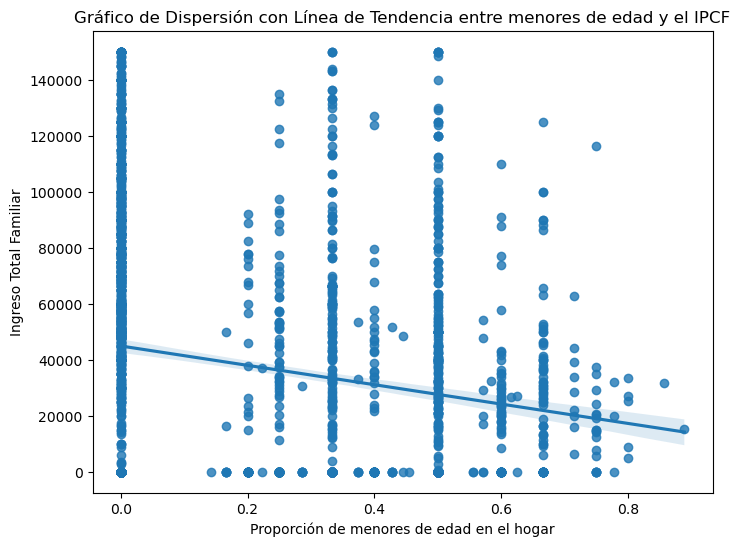

In [39]:
# Graficamos
plt.figure(figsize=(8, 6))
sns.regplot(x='prop_menores', y='IPCF', data=df_graph)
plt.title('Gráfico de Dispersión con Línea de Tendencia entre menores de edad y el IPCF')
plt.xlabel('Proporción de menores de edad en el hogar')
plt.ylabel('Ingreso Total Familiar')
plt.show()

### Inciso 6

In [40]:
# Se importa la base 'tabla_adulto_equiv.xlsx' para luego unirla a la base principal

df_adult_eq = pd.read_excel("tabla_adulto_equiv.xlsx", header=3, usecols="A:C", nrows=25)
df_adult_eq

,Edad,Mujeres,Varones
0,NaN,NaN,NaN
1,Menor de 1 año,0.35,0.35
2,1año,0.37,0.37
3,2 años,0.46,0.46
4,3 años,0.51,0.51
5,4 años,0.55,0.55
6,5 años,0.60,0.60
7,6 años,0.64,0.64
8,7 años,0.66,0.66
9,8 años,0.68,0.68


In [41]:
# Se reemplaza '1año' por '1 año' en la variable 'Edad' para que se pueda hacer un merge adecuado
df_adult_eq['Edad'] = df_adult_eq['Edad'].replace('1año', '1 año')
# Se elimina el único missing de la base debido al formato tabla en Excel
df_adult_eq = df_adult_eq.dropna(subset=['Edad'])
# Se elimina aquellos que tengan menos de 1 año debido a que no se tienen observaciones con esta característica
# en la base principal
df_adult_eq = df_adult_eq[df_adult_eq['Edad'] != "Menor de 1 año"]

In [42]:
# Se transforma la base a un formato long para que se pueda hacer un merge adecuado con la base principal
# para utilizar el sexo y la edad como variables identificadoras
df_adult_eq = pd.melt(df_adult_eq, id_vars=['Edad'], value_vars=['Varones', 'Mujeres'], var_name='Sexo')

In [43]:
# Se crea una nueva columna con el mismo nombre y formato que la base principal para poder hacer el merge
df_adult_eq.loc[df_adult_eq['Sexo'] == "Varones", 'CH04_2'] = 0
df_adult_eq.loc[df_adult_eq['Sexo'] == "Mujeres", 'CH04_2'] = 1
df_adult_eq['CH04_2'] = df_adult_eq['CH04_2'].astype('int64')
# Se renombra la variable 'value' a 'adulto_equiv'
df_adult_eq = df_adult_eq.rename(columns={'value': 'adulto_equiv'})

df_adult_eq

,Edad,Sexo,adulto_equiv,CH04_2
0,1 año,Varones,0.37,0
1,2 años,Varones,0.46,0
2,3 años,Varones,0.51,0
3,4 años,Varones,0.55,0
4,5 años,Varones,0.60,0
5,6 años,Varones,0.64,0
6,7 años,Varones,0.66,0
7,8 años,Varones,0.68,0
8,9 años,Varones,0.69,0
9,10 años,Varones,0.79,0


In [44]:
# Se genera la variable Edad en la base de datos df_eph
conditions = [
    (df_eph['CH06'] == 1),
    (df_eph['CH06'] == 2),
    (df_eph['CH06'] == 3),
    (df_eph['CH06'] == 4),
    (df_eph['CH06'] == 5),
    (df_eph['CH06'] == 6),
    (df_eph['CH06'] == 7),
    (df_eph['CH06'] == 8),
    (df_eph['CH06'] == 9),
    (df_eph['CH06'] == 10),
    (df_eph['CH06'] == 11),
    (df_eph['CH06'] == 12),
    (df_eph['CH06'] == 13),
    (df_eph['CH06'] == 14),
    (df_eph['CH06'] == 15),
    (df_eph['CH06'] == 16),
    (df_eph['CH06'] == 17),
    (df_eph['CH06'].between(18, 29, inclusive='both')),
    (df_eph['CH06'].between(30, 45, inclusive='both')),
    (df_eph['CH06'].between(46, 60, inclusive='both')),
    (df_eph['CH06'].between(61, 75, inclusive='both')),
    (df_eph['CH06'].between(76, 99, inclusive='both'))
]

values = [
    "1 año",
    "2 años",
    "3 años",
    "4 años",
    "5 años",
    "6 años",
    "7 años",
    "8 años",
    "9 años",
    "10 años",
    "11 años",
    "12 años",
    "13 años",
    "14 años",
    "15 años",
    "16 años",
    "17 años",
    "18 a 29 años",
    "30 a 45 años",
    "46 a 60 años",
    "61 a 75 años",
    "más de 75 años"
]

# Aplicar las condiciones y los valores a la nueva columna 'Edad'
df_eph['Edad'] = np.select(conditions, values, default='')

In [45]:
print(df_eph.columns.tolist())

['CODUSU', 'ANO4', 'TRIMESTRE', 'NRO_HOGAR', 'REALIZADA', 'REGION', 'MAS_500', 'PONDERA', 'II1', 'II2', 'IX_TOT', 'IX_MEN10', 'IX_MAYEQ10', 'ITF', 'IPCF', 'PONDIH', 'COMPONENTE', 'CH05', 'CH06', 'P21', 'PONDIIO', 'TOT_P12', 'P47T', 'PONDII', 'V2_M', 'V3_M', 'V4_M', 'V5_M', 'V8_M', 'V9_M', 'V10_M', 'V11_M', 'V12_M', 'V18_M', 'V21_M', 'T_VI', 'AGLOMERADO_33', 'IV1_2', 'IV1_3', 'IV1_4', 'IV1_6', 'IV2_2', 'IV2_3', 'IV2_4', 'IV2_5', 'IV2_6', 'IV2_7', 'IV2_8', 'IV2_9', 'IV2_99', 'IV3_2', 'IV3_3', 'IV3_4', 'IV4_2', 'IV4_3', 'IV4_4', 'IV4_5', 'IV4_6', 'IV4_7', 'IV4_9', 'IV5_2', 'IV6_2', 'IV6_3', 'IV7_2', 'IV7_3', 'IV7_4', 'IV8_2', 'IV9_1', 'IV9_2', 'IV10_1', 'IV10_2', 'IV10_3', 'IV11_1', 'IV11_2', 'IV11_3', 'IV11_4', 'IV12_1_2', 'IV12_2_2', 'IV12_3_2', 'II3_2', 'II4_1_1', 'II4_1_2', 'II4_2_1', 'II4_2_2', 'II4_3_1', 'II4_3_2', 'II5_2', 'II6_2', 'II7_1', 'II7_2', 'II7_3', 'II7_4', 'II7_5', 'II7_6', 'II7_7', 'II7_8', 'II7_9', 'II8_1', 'II8_2', 'II8_3', 'II8_4', 'II9_1', 'II9_2', 'II9_3', 'II9_4',

In [46]:
# Realizamos el merge con la base principal
df_eph_equiv = pd.merge(df_eph, df_adult_eq, on=['Edad', 'CH04_2'], how='left')
df_eph_equiv

,CODUSU,ANO4,TRIMESTRE,NRO_HOGAR,REALIZADA,REGION,MAS_500,PONDERA,II1,II2,...,ADECINDR_10,ADECINDR_12,ADECINDR_13,menores_edad,prop_menores,jh_primario_incompleto,conyug_trabaja,Edad,Sexo,adulto_equiv
0,TQRMNORVYHMOTSCDEIJAH00802517,2023,1,1,1,1,S,1066,4,2,...,False,True,False,0,0.00,0,0,46 a 60 años,Mujeres,0.76
1,TQRMNORVYHMOTSCDEIJAH00802517,2023,1,1,1,1,S,1066,4,2,...,False,False,False,0,0.00,0,0,18 a 29 años,Mujeres,0.76
2,TQRMNOSQRHLLTTCDEIJAH00719390,2023,1,1,1,1,S,2270,4,1,...,False,False,False,0,0.00,0,1,30 a 45 años,Varones,1.00
3,TQRMNOSQRHLLTTCDEIJAH00719390,2023,1,1,1,1,S,2270,4,1,...,False,False,False,0,0.00,0,1,30 a 45 años,Mujeres,0.77
4,TQSMNOSQRHLLTTCDEIJAH00719389,2023,1,1,1,1,S,2161,3,1,...,False,False,False,0,0.00,0,0,más de 75 años,Mujeres,0.63
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7135,TQRMNOSSQHKOOMCDEIJAH00802644,2023,1,1,1,1,S,3381,3,2,...,False,False,False,3,0.75,0,0,18 a 29 años,Mujeres,0.76
7136,TQRMNOSSQHKOOMCDEIJAH00802644,2023,1,1,1,1,S,3381,3,2,...,False,False,False,3,0.75,0,0,13 años,Mujeres,0.76
7137,TQRMNOSSQHKOOMCDEIJAH00802644,2023,1,1,1,1,S,3381,3,2,...,False,False,False,3,0.75,0,0,7 años,Varones,0.66
7138,TQRMNORYPHJKNPCDEIJAH00794297,2023,1,1,1,1,S,521,3,2,...,False,False,False,1,0.50,0,0,61 a 75 años,Mujeres,0.67


In [47]:
# Ahora se crea un data frame que contenga la suma de las necesidades energéticas de los miembros de cada hogar
ad_equiv_hogar = df_eph_equiv.groupby(['CODUSU', 'NRO_HOGAR'])['adulto_equiv'].sum().reset_index()
# Se cambia el nombre de la variable a 'ad_equiv_hogar'
ad_equiv_hogar = ad_equiv_hogar.rename(columns={'adulto_equiv':'ad_equiv_hogar'})
# Se realiza el merge con la base principal con las necesidades energéticas por hogar
df_eph_equiv = pd.merge(df_eph_equiv, ad_equiv_hogar, on=['CODUSU', 'NRO_HOGAR'], how='left')

df_eph_equiv

,CODUSU,ANO4,TRIMESTRE,NRO_HOGAR,REALIZADA,REGION,MAS_500,PONDERA,II1,II2,...,ADECINDR_12,ADECINDR_13,menores_edad,prop_menores,jh_primario_incompleto,conyug_trabaja,Edad,Sexo,adulto_equiv,ad_equiv_hogar
0,TQRMNORVYHMOTSCDEIJAH00802517,2023,1,1,1,1,S,1066,4,2,...,True,False,0,0.00,0,0,46 a 60 años,Mujeres,0.76,1.52
1,TQRMNORVYHMOTSCDEIJAH00802517,2023,1,1,1,1,S,1066,4,2,...,False,False,0,0.00,0,0,18 a 29 años,Mujeres,0.76,1.52
2,TQRMNOSQRHLLTTCDEIJAH00719390,2023,1,1,1,1,S,2270,4,1,...,False,False,0,0.00,0,1,30 a 45 años,Varones,1.00,1.77
3,TQRMNOSQRHLLTTCDEIJAH00719390,2023,1,1,1,1,S,2270,4,1,...,False,False,0,0.00,0,1,30 a 45 años,Mujeres,0.77,1.77
4,TQSMNOSQRHLLTTCDEIJAH00719389,2023,1,1,1,1,S,2161,3,1,...,False,False,0,0.00,0,0,más de 75 años,Mujeres,0.63,0.63
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7135,TQRMNOSSQHKOOMCDEIJAH00802644,2023,1,1,1,1,S,3381,3,2,...,False,False,3,0.75,0,0,18 a 29 años,Mujeres,0.76,2.95
7136,TQRMNOSSQHKOOMCDEIJAH00802644,2023,1,1,1,1,S,3381,3,2,...,False,False,3,0.75,0,0,13 años,Mujeres,0.76,2.95
7137,TQRMNOSSQHKOOMCDEIJAH00802644,2023,1,1,1,1,S,3381,3,2,...,False,False,3,0.75,0,0,7 años,Varones,0.66,2.95
7138,TQRMNORYPHJKNPCDEIJAH00794297,2023,1,1,1,1,S,521,3,2,...,False,False,1,0.50,0,0,61 a 75 años,Mujeres,0.67,1.69


In [48]:
# Se crea una submuestra con los que respondieron sobre su ingreso total familiar
respondieron = df_eph_equiv.loc[df_eph_equiv['ITF'] != 0]
print(len(respondieron))

4181


In [49]:
# Ahora los que no respondieron
norespondieron = df_eph_equiv.loc[df_eph_equiv['ITF'] == 0]
print(len(norespondieron), 'personas no respondieron cuál es su ingreso total familiar')

2959 personas no respondieron cuál es su ingreso total familiar


In [50]:
# Agregamos la columna 'ingreso_necesario' la cual es resultado de multiplicar el valor de la Canasta Básica
# Total en GBA por las necesidades energéticas por hogar
respondieron['ingreso_necesario'] = respondieron['ad_equiv_hogar']*57371.05
respondieron

/var/folders/cf/7tck_wvs6zsfkq55v6g6fc0w0000gn/T/ipykernel_10872/11768579.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  respondieron['ingreso_necesario'] = respondieron['ad_equiv_hogar']*57371.05


,CODUSU,ANO4,TRIMESTRE,NRO_HOGAR,REALIZADA,REGION,MAS_500,PONDERA,II1,II2,...,ADECINDR_13,menores_edad,prop_menores,jh_primario_incompleto,conyug_trabaja,Edad,Sexo,adulto_equiv,ad_equiv_hogar,ingreso_necesario
2,TQRMNOSQRHLLTTCDEIJAH00719390,2023,1,1,1,1,S,2270,4,1,...,False,0,0.00,0,1,30 a 45 años,Varones,1.00,1.77,101546.7585
3,TQRMNOSQRHLLTTCDEIJAH00719390,2023,1,1,1,1,S,2270,4,1,...,False,0,0.00,0,1,30 a 45 años,Mujeres,0.77,1.77,101546.7585
4,TQSMNOSQRHLLTTCDEIJAH00719389,2023,1,1,1,1,S,2161,3,1,...,False,0,0.00,0,0,más de 75 años,Mujeres,0.63,0.63,36143.7615
5,TQRMNORTUHKOQQCDEIJAH00780489,2023,1,1,1,1,S,3097,3,1,...,False,0,0.00,0,0,más de 75 años,Mujeres,0.63,0.63,36143.7615
6,TQRMNOUTRHKNQMCDEIJAH00802590,2023,1,1,1,1,S,2571,2,1,...,False,0,0.00,0,0,30 a 45 años,Varones,1.00,1.00,57371.0500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7135,TQRMNOSSQHKOOMCDEIJAH00802644,2023,1,1,1,1,S,3381,3,2,...,False,3,0.75,0,0,18 a 29 años,Mujeres,0.76,2.95,169244.5975
7136,TQRMNOSSQHKOOMCDEIJAH00802644,2023,1,1,1,1,S,3381,3,2,...,False,3,0.75,0,0,13 años,Mujeres,0.76,2.95,169244.5975
7137,TQRMNOSSQHKOOMCDEIJAH00802644,2023,1,1,1,1,S,3381,3,2,...,False,3,0.75,0,0,7 años,Varones,0.66,2.95,169244.5975
7138,TQRMNORYPHJKNPCDEIJAH00794297,2023,1,1,1,1,S,521,3,2,...,False,1,0.50,0,0,61 a 75 años,Mujeres,0.67,1.69,96957.0745


Se agrega la columna 'pobre' a la base 'respondieron'. Esta es una variable dummy que toma el valor 1 cuando el Ingreso Total Familiar es menor al ingreso necesario para cubrir las necesidades básicas y 0 si ocurre lo contrario.

In [51]:
respondieron['pobre'] = (respondieron['ITF'] < respondieron['ingreso_necesario']).astype(int)

/var/folders/cf/7tck_wvs6zsfkq55v6g6fc0w0000gn/T/ipykernel_10872/1131476788.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  respondieron['pobre'] = (respondieron['ITF'] < respondieron['ingreso_necesario']).astype(int)


### Inciso 7

#### Identificacion de hogares pobres

Primeramente, a efectos de poder contrastar con la predicción obtenida al final de la Parte III, se computa la cantidad de personas pobres.

In [52]:
# Identificamos pobres como en el TP3

pobres = (respondieron['pobre'] == 1).sum()
print('Se identificó a', pobres, 'personas pobres')

Se identificó a 1555 personas pobres


In [53]:
# Se crea una variable que identifica a los hogares, a partir de CODUSU (que identifica viviendas) y NRO_HOGAR (que identifica
# hogares dentro de una misma vivienda).
respondieron['id_hogar'] = respondieron['CODUSU'].astype(str) + '_' + respondieron['NRO_HOGAR'].astype(str)

/var/folders/cf/7tck_wvs6zsfkq55v6g6fc0w0000gn/T/ipykernel_10872/4117641682.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  respondieron['id_hogar'] = respondieron['CODUSU'].astype(str) + '_' + respondieron['NRO_HOGAR'].astype(str)


In [54]:
# Construimos otro dataset con un individuo por hogar
resp_hogares = respondieron.groupby('id_hogar').first().reset_index()
resp_hogares

,id_hogar,CODUSU,ANO4,TRIMESTRE,NRO_HOGAR,REALIZADA,REGION,MAS_500,PONDERA,II1,...,menores_edad,prop_menores,jh_primario_incompleto,conyug_trabaja,Edad,Sexo,adulto_equiv,ad_equiv_hogar,ingreso_necesario,pobre
0,TQRMNOPPQHJNOPCDEIJAH00802435_1,TQRMNOPPQHJNOPCDEIJAH00802435,2023,1,1,1,1,S,1667,5,...,0,0.000000,0,0,46 a 60 años,Varones,1.00,3.54,203093.5170,0
1,TQRMNOPPQHKMQRCDEIJAH00780809_1,TQRMNOPPQHKMQRCDEIJAH00780809,2023,1,1,1,1,S,3577,2,...,3,0.500000,0,1,30 a 45 años,Mujeres,0.77,4.48,257022.3040,1
2,TQRMNOPPQHLNKTCDEIIAD00780107_1,TQRMNOPPQHLNKTCDEIIAD00780107,2023,1,1,1,1,S,3536,2,...,1,0.333333,0,1,30 a 45 años,Mujeres,0.77,2.14,122774.0470,0
3,TQRMNOPPQHLOKTCDEIJAH00719666_1,TQRMNOPPQHLOKTCDEIJAH00719666,2023,1,1,1,1,S,196,1,...,0,0.000000,0,0,46 a 60 años,Varones,1.00,1.00,57371.0500,0
4,TQRMNOPPQHMKLSCDEIIAD00801791_1,TQRMNOPPQHMKLSCDEIIAD00801791,2023,1,1,1,1,S,80,3,...,1,0.500000,0,0,30 a 45 años,Mujeres,0.77,1.41,80893.1805,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1609,TQTMNOQWYHKNQLCDEIJAH00785853_1,TQTMNOQWYHKNQLCDEIJAH00785853,2023,1,1,1,1,S,2229,3,...,1,0.333333,0,1,30 a 45 años,Varones,1.00,2.59,148591.0195,0
1610,TQTMNORQXHMOSQCDEIJAH00802270_1,TQTMNORQXHMOSQCDEIJAH00802270,2023,1,1,1,1,S,3150,2,...,1,0.333333,0,1,46 a 60 años,Varones,1.00,3.03,173834.2815,1
1611,TQTMNORTQHLMNUCDEIJAH00793701_1,TQTMNORTQHLMNUCDEIJAH00793701,2023,1,1,1,1,S,1679,1,...,2,0.500000,0,1,30 a 45 años,Varones,1.00,3.58,205388.3590,0
1612,TQUMNOQTRHKMPSCDEIJAH00801913_1,TQUMNOQTRHKMPSCDEIJAH00801913,2023,1,1,1,1,S,2264,1,...,2,0.666667,0,0,30 a 45 años,Mujeres,0.77,2.17,124495.1785,1


In [55]:
#Tasa de pobreza para GBA
tasa_pobreza = np.average(resp_hogares['pobre'], weights=resp_hogares['PONDIH'])*100
print(f'La tasa de pobreza es de {tasa_pobreza:.2f}%')

La tasa de pobreza es de 28.32%
